In [133]:
import joblib
import pandas as pd
import numpy as np

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


df = joblib.load("/home/lavrenchuk/TS_Project_Favorita/data/processed/features_agg.joblib")
print(df.shape)
print(df.index.min(), df.index.max())
display(df.tail())

(1688, 27)
0 1687


,date,unit_sales,unit_sales_log,month,day_of_month,weekday,is_workday,lag_log_1,lag_log_7,lag_log_14,...,dow_sin,dow_cos,year_sin,year_cos,is_holiday,before_holiday,after_holiday,is_christmas,pre_christmas,post_christmas
1683,2017-08-11,80783.227,11.299537,8,11,4,1,10.984767,11.172635,11.192696,...,-0.433884,-0.900969,-0.866025,-0.5,0,0,1,0,0,0
1684,2017-08-12,77928.860,11.263564,8,12,5,0,11.299537,11.399004,11.469589,...,-0.974928,-0.222521,-0.866025,-0.5,0,0,0,0,0,0
1685,2017-08-13,92090.859,11.430542,8,13,6,0,11.263564,11.571467,11.615288,...,-0.781831,0.623490,-0.866025,-0.5,0,0,0,0,0,0
1686,2017-08-14,69852.929,11.154162,8,14,0,1,11.430542,11.195912,11.342291,...,0.000000,1.000000,-0.866025,-0.5,0,1,0,0,0,0
1687,2017-08-15,80080.046,11.290794,8,15,1,1,11.154162,11.110238,11.509225,...,0.781831,0.623490,-0.866025,-0.5,1,0,0,0,0,0


## Prophet (without holidays)

Test period: 2017-05-18 00:00:00 → 2017-08-15 00:00:00


03:01:25 - cmdstanpy - INFO - Chain [1] start processing
03:01:25 - cmdstanpy - INFO - Chain [1] done processing



Forecast 90 days (real sales):
           ds     yhat_real  yhat_lower_real  yhat_upper_real
0  2017-05-18  58140.698538     22734.868897    142612.211413
1  2017-05-19  63685.358201     25422.079142    158696.091505
2  2017-05-20  89732.586154     34673.995073    227675.452460
3  2017-05-21  88531.853592     34667.782356    234342.248969
4  2017-05-22  75216.556640     31176.599366    196979.962895
..        ...           ...              ...              ...
85 2017-08-11  69404.225586     28591.041449    170256.188641
86 2017-08-12  98871.506422     38446.868407    239317.656279
87 2017-08-13  98539.797561     37349.121156    239776.784390
88 2017-08-14  84468.683983     33454.580978    212421.481309
89 2017-08-15  79570.601319     31807.977913    190208.267031

[90 rows x 4 columns]


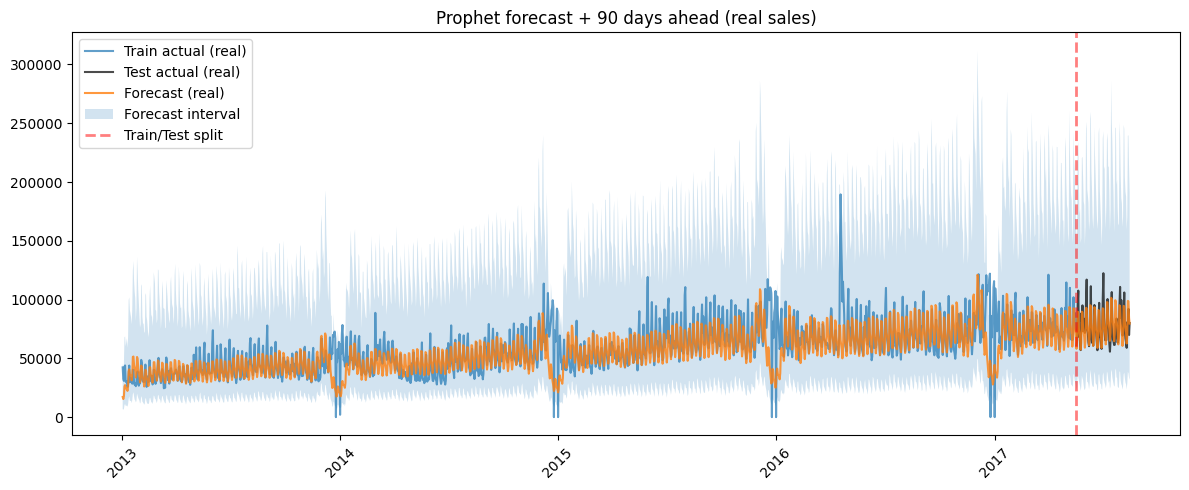

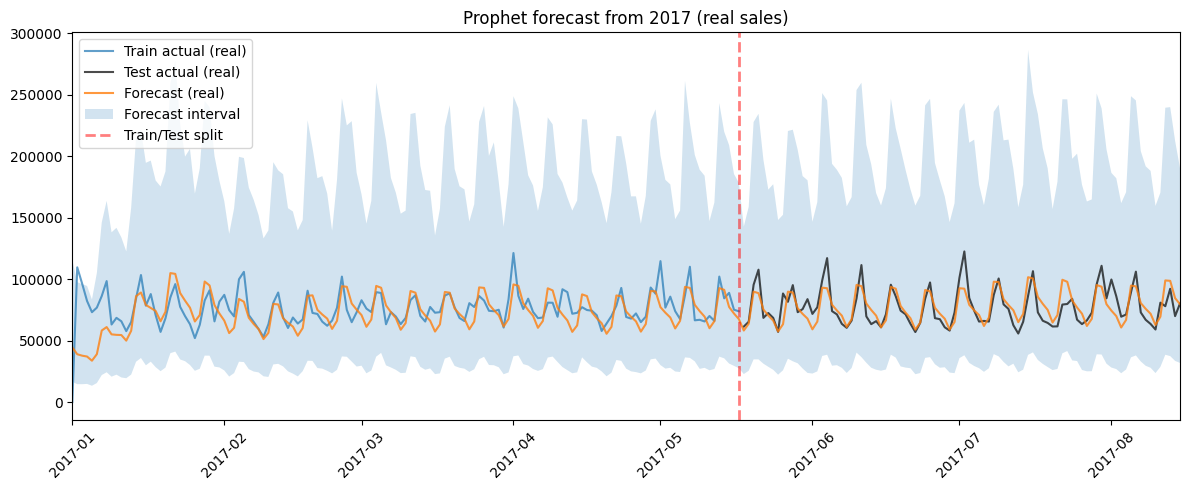


Test metrics:
MAE_30  = 7797.23
RMSE_30 = 10295.19
MAPE_30 = 9.36%

MAE_60  = 7057.22
RMSE_60 = 9426.20
MAPE_60 = 8.65%

MAE_90  = 7965.66
RMSE_90 = 10198.52
MAPE_90 = 9.99%


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error


df_prophet = df.copy()

df_prophet = df_prophet.reset_index().rename(columns={
    'date': 'ds',          
    'unit_sales_log': 'y'  #будуємо на основі логарифму таргету
})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Спліт на трейн/тест, тест на останніх 90 днях
train, test = df_prophet[:-90], df_prophet[-90:]
print("Test period:", test['ds'].min(), "→", test['ds'].max())

# Модель Prophet 
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

model.fit(train)

# Прогноз на 90 днів 
future = model.make_future_dataframe(periods=90, freq='D')
forecast = model.predict(future)

# Перехід з логарифму до натуральних продажів для forecast
forecast['yhat_real'] = np.exp(forecast['yhat'])
forecast['yhat_lower_real'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_real'] = np.exp(forecast['yhat_upper'])

# Беремо тільки 90 майбутніх днів після train
forecast_90 = forecast.tail(90).reset_index(drop=True)
forecast_60 = forecast_90.iloc[:60]
forecast_30 = forecast_90.iloc[:30]

# Таблиці прогнозів у натуральних одиницях
print("\nForecast 90 days (real sales):")
print(forecast_90[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

# фактичні продажі у натуральних одиницях
train_real = train.copy()
test_real = test.copy()
train_real['y_real'] = np.exp(train_real['y'])
test_real['y_real'] = np.exp(test_real['y'])



# Графік прогнозу на весь період в натуральних одиницях
# Так як графік буде в натуральних одиницях, а таргет був логарифмом - прийдеться будувати вручну, а не через model.plot
plt.figure(figsize=(12, 5))

# історичні значення
plt.plot(train_real['ds'], train_real['y_real'],
         label='Train actual (real)', alpha=0.7)
plt.plot(test_real['ds'], test_real['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

# прогнозні значення
plt.plot(forecast['ds'], forecast['yhat_real'],
         label='Forecast (real)', alpha=0.8)

# довірчий інтервал
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower_real'],
    forecast['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

# межа між вибірками трейн і тест
plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.title('Prophet forecast + 90 days ahead (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



#Укрупнений графік, тільки з 2017 року
plt.figure(figsize=(12, 5))

mask_2017 = forecast['ds'] >= pd.Timestamp("2017-01-01")

plt.plot(train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Train actual (real)', alpha=0.7)

plt.plot(test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

plt.plot(forecast[mask_2017]['ds'],
         forecast[mask_2017]['yhat_real'],
         label='Forecast (real)', alpha=0.8)

plt.fill_between(
    forecast[mask_2017]['ds'],
    forecast[mask_2017]['yhat_lower_real'],
    forecast[mask_2017]['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.xlim(pd.Timestamp("2017-01-01"), forecast['ds'].max())
plt.title('Prophet forecast from 2017 (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Метрики в натуральному масштабі (на 90-денному тесті)

# привʼязуємо прогноз до тестових дат
forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

# переходимо до натуральних одиниць
df_eval['y_real'] = np.exp(df_eval['y'])
df_eval['yhat_real'] = np.exp(df_eval['yhat'])

def metrics(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mae, rmse, mape

MAE_90, RMSE_90, MAPE_90 = metrics(df_eval['y_real'], df_eval['yhat_real'])
MAE_60, RMSE_60, MAPE_60 = metrics(df_eval['y_real'][:60], df_eval['yhat_real'][:60])
MAE_30, RMSE_30, MAPE_30 = metrics(df_eval['y_real'][:30], df_eval['yhat_real'][:30])

print("\nTest metrics:")
print(f"MAE_30  = {MAE_30:.2f}")
print(f"RMSE_30 = {RMSE_30:.2f}")
print(f"MAPE_30 = {MAPE_30:.2f}%")

print(f"\nMAE_60  = {MAE_60:.2f}")
print(f"RMSE_60 = {RMSE_60:.2f}")
print(f"MAPE_60 = {MAPE_60:.2f}%")

print(f"\nMAE_90  = {MAE_90:.2f}")
print(f"RMSE_90 = {RMSE_90:.2f}")
print(f"MAPE_90 = {MAPE_90:.2f}%")

## Prophet with holidays



03:01:26 - cmdstanpy - INFO - Chain [1] start processing


             ds  holiday
1665 2017-07-24  holiday
1666 2017-07-25  holiday
1677 2017-08-05  holiday
1682 2017-08-10  holiday
1687 2017-08-15  holiday


03:01:26 - cmdstanpy - INFO - Chain [1] done processing



Forecast 90 days (real sales):
           ds      yhat_real  yhat_lower_real  yhat_upper_real
0  2017-05-18   60824.687478     23772.889567    143846.546512
1  2017-05-19   66629.608686     26809.615061    171891.838161
2  2017-05-20   93057.530169     36184.874476    238788.348325
3  2017-05-21   91309.747604     37686.779029    231799.523397
4  2017-05-22   77993.580572     31710.648283    193189.696266
..        ...            ...              ...              ...
85 2017-08-11   73522.621325     27725.710789    209290.736734
86 2017-08-12  104071.757788     41859.696525    255825.707381
87 2017-08-13  103433.903514     41373.498823    269570.850116
88 2017-08-14   89399.014924     34503.450642    226874.098611
89 2017-08-15   61000.025697     23557.650882    153948.591347

[90 rows x 4 columns]


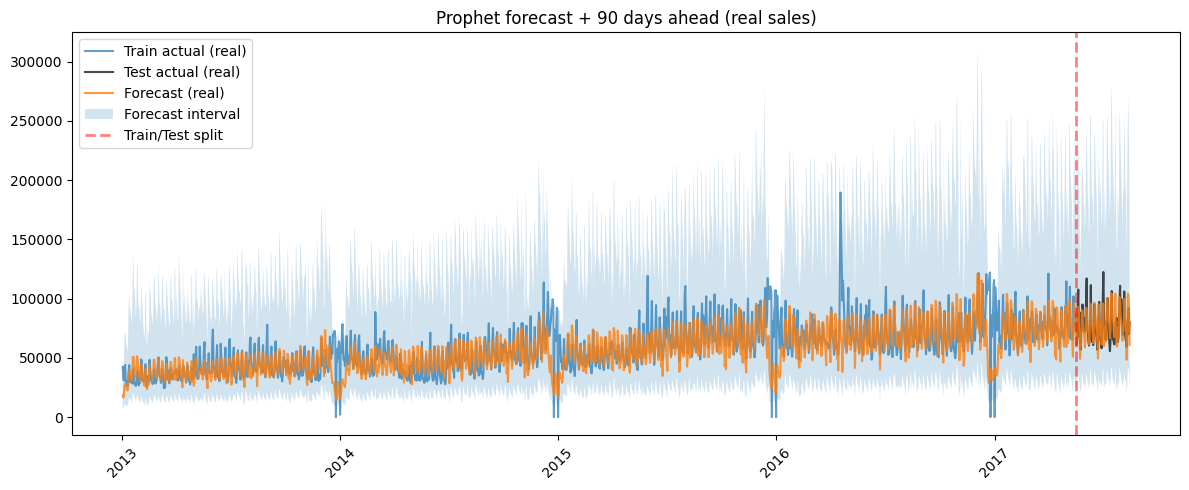

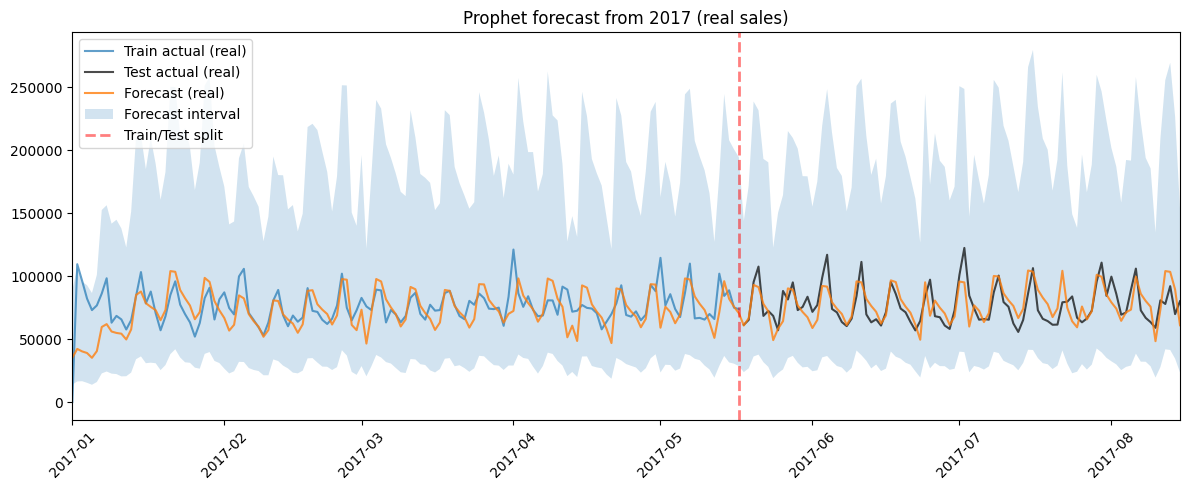


Test metrics:
MAE_30  = 8353.06
RMSE_30 = 10888.93
MAPE_30 = 10.27%

MAE_60  = 8880.65
RMSE_60 = 11370.28
MAPE_60 = 11.21%

MAE_90  = 9766.90
RMSE_90 = 12109.21
MAPE_90 = 12.56%


In [135]:
holidays_df = df_prophet.loc[df_prophet['is_holiday'] == 1, ['ds']].copy()
holidays_df['holiday'] = 'holiday'
print(holidays_df.tail())

# Модель Prophet зі святами
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    holidays=holidays_df
)

model.fit(train)

# Прогноз на 90 днів 
future = model.make_future_dataframe(periods=90, freq='D')
forecast = model.predict(future)

# Перехід з логарифму до натуральних продажів для forecast
forecast['yhat_real'] = np.exp(forecast['yhat'])
forecast['yhat_lower_real'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_real'] = np.exp(forecast['yhat_upper'])

# Беремо тільки 90 майбутніх днів після train
forecast_90 = forecast.tail(90).reset_index(drop=True)
forecast_60 = forecast_90.iloc[:60]
forecast_30 = forecast_90.iloc[:30]

# Таблиці прогнозів у натуральних одиницях
print("\nForecast 90 days (real sales):")
print(forecast_90[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

# фактичні продажі у натуральних одиницях
train_real = train.copy()
test_real = test.copy()
train_real['y_real'] = np.exp(train_real['y'])
test_real['y_real'] = np.exp(test_real['y'])



# Графік прогнозу на весь період в натуральних одиницях
plt.figure(figsize=(12, 5))

# історичні значення
plt.plot(train_real['ds'], train_real['y_real'],
         label='Train actual (real)', alpha=0.7)
plt.plot(test_real['ds'], test_real['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

# прогнозні значення
plt.plot(forecast['ds'], forecast['yhat_real'],
         label='Forecast (real)', alpha=0.8)

# довірчий інтервал
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower_real'],
    forecast['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

# межа між вибірками трейн і тест
plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.title('Prophet forecast + 90 days ahead (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



#Укрупнений графік, тільки з 2017 року
plt.figure(figsize=(12, 5))

mask_2017 = forecast['ds'] >= pd.Timestamp("2017-01-01")

plt.plot(train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Train actual (real)', alpha=0.7)

plt.plot(test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

plt.plot(forecast[mask_2017]['ds'],
         forecast[mask_2017]['yhat_real'],
         label='Forecast (real)', alpha=0.8)

plt.fill_between(
    forecast[mask_2017]['ds'],
    forecast[mask_2017]['yhat_lower_real'],
    forecast[mask_2017]['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.xlim(pd.Timestamp("2017-01-01"), forecast['ds'].max())
plt.title('Prophet forecast from 2017 (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Метрики в натуральному масштабі (на 90-денному тесті)

# привʼязуємо прогноз до тестових дат
forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

# переходимо до натуральних одиниць
df_eval['y_real'] = np.exp(df_eval['y'])
df_eval['yhat_real'] = np.exp(df_eval['yhat'])

def metrics(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mae, rmse, mape

MAE_90, RMSE_90, MAPE_90 = metrics(df_eval['y_real'], df_eval['yhat_real'])
MAE_60, RMSE_60, MAPE_60 = metrics(df_eval['y_real'][:60], df_eval['yhat_real'][:60])
MAE_30, RMSE_30, MAPE_30 = metrics(df_eval['y_real'][:30], df_eval['yhat_real'][:30])

print("\nTest metrics:")
print(f"MAE_30  = {MAE_30:.2f}")
print(f"RMSE_30 = {RMSE_30:.2f}")
print(f"MAPE_30 = {MAPE_30:.2f}%")

print(f"\nMAE_60  = {MAE_60:.2f}")
print(f"RMSE_60 = {RMSE_60:.2f}")
print(f"MAPE_60 = {MAPE_60:.2f}%")

print(f"\nMAE_90  = {MAE_90:.2f}")
print(f"RMSE_90 = {RMSE_90:.2f}")
print(f"MAPE_90 = {MAPE_90:.2f}%")

Результат гірше за модель без змінної "свята", що дивно... можливо варто перевірити змінні before_holiday, after_holiday, можливо вони впливають більше.

## Prophet with before-, after-, holidays, but like tree additional regressors

03:01:27 - cmdstanpy - INFO - Chain [1] start processing
03:01:27 - cmdstanpy - INFO - Chain [1] done processing



Forecast 90 days (real sales):
           ds      yhat_real  yhat_lower_real  yhat_upper_real
0  2017-05-18   63956.676494     24279.859757    165408.161051
1  2017-05-19   69880.901961     29757.779550    173940.543832
2  2017-05-20   97464.470451     39812.191695    232488.563645
3  2017-05-21   95158.243814     37134.710973    233627.641856
4  2017-05-22   80422.391807     33049.517018    212749.242328
..        ...            ...              ...              ...
85 2017-08-11   57055.092187     22951.398043    137055.385015
86 2017-08-12  110504.684240     45467.607538    270107.982872
87 2017-08-13  109603.036670     44596.453912    272307.623392
88 2017-08-14   84228.389334     33014.270853    222313.529604
89 2017-08-15   69011.442598     27848.056397    169807.676571

[90 rows x 4 columns]


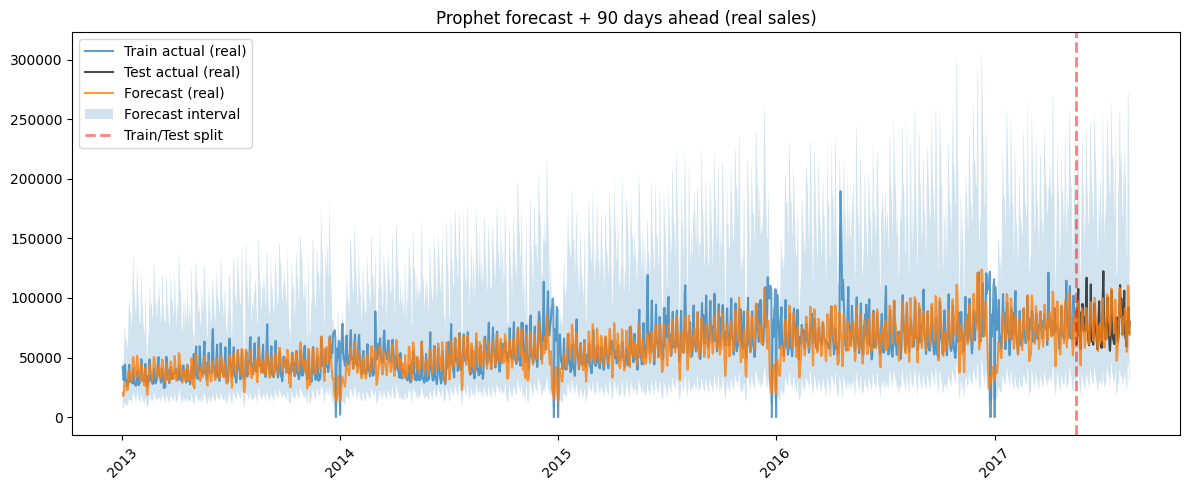

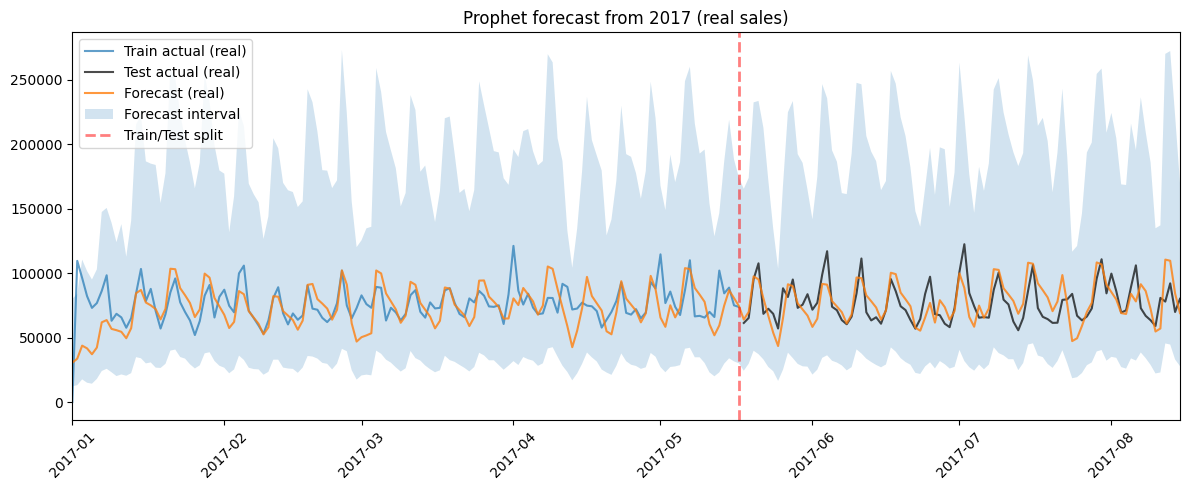


Test metrics:
MAE_30  = 9030.39
RMSE_30 = 11094.17
MAPE_30 = 11.47%

MAE_60  = 9835.36
RMSE_60 = 12046.17
MAPE_60 = 12.64%

MAE_90  = 11027.69
RMSE_90 = 13571.59
MAPE_90 = 14.27%


In [136]:

# Модель Prophet зі святами
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
model.add_regressor('before_holiday')
model.add_regressor('after_holiday')
model.add_regressor('is_holiday')
model.fit(train)

# Прогноз на 90 днів 
future = model.make_future_dataframe(periods=90, freq='D')
future = future.merge(
    df_prophet[['ds', 'before_holiday', 'after_holiday', 'is_holiday']],
    on='ds',
    how='left'
)

future[['before_holiday', 'after_holiday', 'is_holiday']] = future[['before_holiday', 'after_holiday', 'is_holiday']].fillna(0)
forecast = model.predict(future)

# Перехід з логарифму до натуральних продажів для forecast
forecast['yhat_real'] = np.exp(forecast['yhat'])
forecast['yhat_lower_real'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_real'] = np.exp(forecast['yhat_upper'])

# Беремо тільки 90 майбутніх днів після train
forecast_90 = forecast.tail(90).reset_index(drop=True)
forecast_60 = forecast_90.iloc[:60]
forecast_30 = forecast_90.iloc[:30]

# Таблиці прогнозів у натуральних одиницях
print("\nForecast 90 days (real sales):")
print(forecast_90[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

# фактичні продажі у натуральних одиницях
train_real = train.copy()
test_real = test.copy()
train_real['y_real'] = np.exp(train_real['y'])
test_real['y_real'] = np.exp(test_real['y'])



# Графік прогнозу на весь період в натуральних одиницях
plt.figure(figsize=(12, 5))

# історичні значення
plt.plot(train_real['ds'], train_real['y_real'],
         label='Train actual (real)', alpha=0.7)
plt.plot(test_real['ds'], test_real['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

# прогнозні значення
plt.plot(forecast['ds'], forecast['yhat_real'],
         label='Forecast (real)', alpha=0.8)

# довірчий інтервал
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower_real'],
    forecast['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

# межа між вибірками трейн і тест
plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.title('Prophet forecast + 90 days ahead (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



#Укрупнений графік, тільки з 2017 року
plt.figure(figsize=(12, 5))

mask_2017 = forecast['ds'] >= pd.Timestamp("2017-01-01")

plt.plot(train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Train actual (real)', alpha=0.7)

plt.plot(test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

plt.plot(forecast[mask_2017]['ds'],
         forecast[mask_2017]['yhat_real'],
         label='Forecast (real)', alpha=0.8)

plt.fill_between(
    forecast[mask_2017]['ds'],
    forecast[mask_2017]['yhat_lower_real'],
    forecast[mask_2017]['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.xlim(pd.Timestamp("2017-01-01"), forecast['ds'].max())
plt.title('Prophet forecast from 2017 (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Метрики в натуральному масштабі (на 90-денному тесті)

# привʼязуємо прогноз до тестових дат
forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

# переходимо до натуральних одиниць
df_eval['y_real'] = np.exp(df_eval['y'])
df_eval['yhat_real'] = np.exp(df_eval['yhat'])

def metrics(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mae, rmse, mape

MAE_90, RMSE_90, MAPE_90 = metrics(df_eval['y_real'], df_eval['yhat_real'])
MAE_60, RMSE_60, MAPE_60 = metrics(df_eval['y_real'][:60], df_eval['yhat_real'][:60])
MAE_30, RMSE_30, MAPE_30 = metrics(df_eval['y_real'][:30], df_eval['yhat_real'][:30])

print("\nTest metrics:")
print(f"MAE_30  = {MAE_30:.2f}")
print(f"RMSE_30 = {RMSE_30:.2f}")
print(f"MAPE_30 = {MAPE_30:.2f}%")

print(f"\nMAE_60  = {MAE_60:.2f}")
print(f"RMSE_60 = {RMSE_60:.2f}")
print(f"MAPE_60 = {MAPE_60:.2f}%")

print(f"\nMAE_90  = {MAE_90:.2f}")
print(f"RMSE_90 = {RMSE_90:.2f}")
print(f"MAPE_90 = {MAPE_90:.2f}%")

Результат ще гірше... кумедно =) 

Можливо в тестовій виборці (90 днів) немає свят?

Можливо варто виділити окремі типи свят, а не додавати всі підряд. Наприклад - Різдво, Новий + дні напередодні і після. 

## Prophet with Сhristmas + pre-, post- Chrisrmas days

03:01:29 - cmdstanpy - INFO - Chain [1] start processing
03:01:29 - cmdstanpy - INFO - Chain [1] done processing



Forecast 90 days (real sales):
           ds     yhat_real  yhat_lower_real  yhat_upper_real
0  2017-05-18  59978.969893     31095.239993    116589.358303
1  2017-05-19  65868.743539     33982.919661    124865.088674
2  2017-05-20  88575.201992     44699.038097    163993.735887
3  2017-05-21  91819.383875     47953.966379    170001.915952
4  2017-05-22  74053.649960     38984.945203    138448.204318
..        ...           ...              ...              ...
85 2017-08-11  69056.712624     37376.903323    133083.652665
86 2017-08-12  93476.646119     47652.894514    177847.337808
87 2017-08-13  97574.767994     52504.854515    177903.289306
88 2017-08-14  79253.526634     40754.847198    152057.041507
89 2017-08-15  74700.782676     41137.815912    140712.528129

[90 rows x 4 columns]


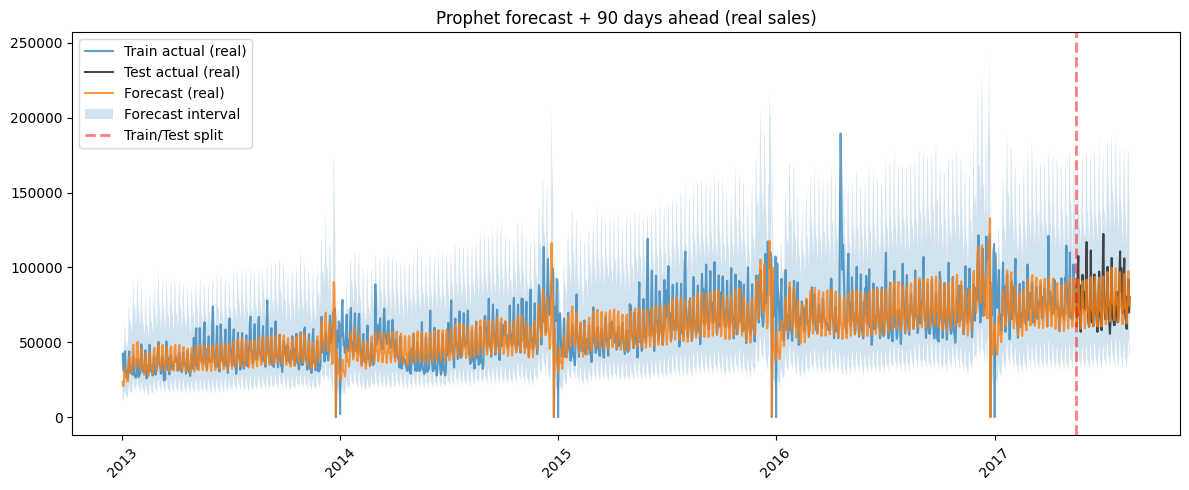

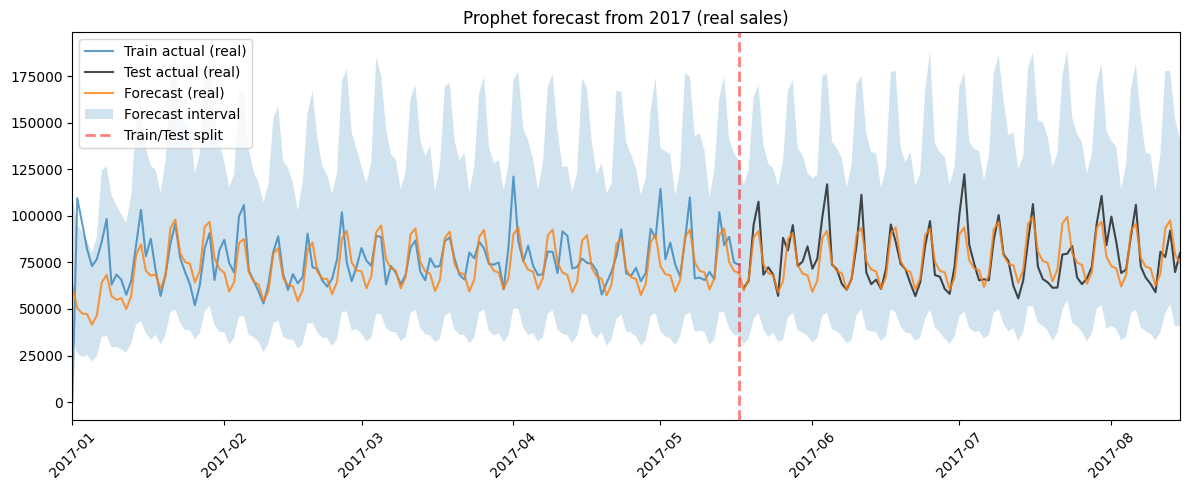


Test metrics:
MAE_30  = 6848.67
RMSE_30 = 9616.00
MAPE_30 = 8.03%

MAE_60  = 6417.33
RMSE_60 = 8777.15
MAPE_60 = 7.81%

MAE_90  = 7184.75
RMSE_90 = 9338.86
MAPE_90 = 8.95%


In [137]:
# Модель Prophet зі святами
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
model.add_regressor('is_christmas') 
model.add_regressor('pre_christmas')
model.add_regressor('post_christmas')
model.fit(train)

# Прогноз на 90 днів 
future = model.make_future_dataframe(periods=90, freq='D')
future = future.merge(
    df_prophet[['ds', 'is_christmas', 'pre_christmas', 'post_christmas']],
    on='ds',
    how='left'
)

future[['is_christmas', 'pre_christmas', 'post_christmas']] = future[['is_christmas', 'pre_christmas', 'post_christmas']].fillna(0)
forecast = model.predict(future)

# Перехід з логарифму до натуральних продажів для forecast
forecast['yhat_real'] = np.exp(forecast['yhat'])
forecast['yhat_lower_real'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_real'] = np.exp(forecast['yhat_upper'])

# Беремо тільки 90 майбутніх днів після train
forecast_90 = forecast.tail(90).reset_index(drop=True)
forecast_60 = forecast_90.iloc[:60]
forecast_30 = forecast_90.iloc[:30]

# Таблиці прогнозів у натуральних одиницях
print("\nForecast 90 days (real sales):")
print(forecast_90[['ds', 'yhat_real', 'yhat_lower_real', 'yhat_upper_real']])

# фактичні продажі у натуральних одиницях
train_real = train.copy()
test_real = test.copy()
train_real['y_real'] = np.exp(train_real['y'])
test_real['y_real'] = np.exp(test_real['y'])



# Графік прогнозу на весь період в натуральних одиницях
plt.figure(figsize=(12, 5))

# історичні значення
plt.plot(train_real['ds'], train_real['y_real'],
         label='Train actual (real)', alpha=0.7)
plt.plot(test_real['ds'], test_real['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

# прогнозні значення
plt.plot(forecast['ds'], forecast['yhat_real'],
         label='Forecast (real)', alpha=0.8)

# довірчий інтервал
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower_real'],
    forecast['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

# межа між вибірками трейн і тест
plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.title('Prophet forecast + 90 days ahead (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



#Укрупнений графік, тільки з 2017 року
plt.figure(figsize=(12, 5))

mask_2017 = forecast['ds'] >= pd.Timestamp("2017-01-01")

plt.plot(train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         train_real[train_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Train actual (real)', alpha=0.7)

plt.plot(test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['ds'],
         test_real[test_real['ds'] >= pd.Timestamp("2017-01-01")]['y_real'],
         label='Test actual (real)', alpha=0.7, color='black')

plt.plot(forecast[mask_2017]['ds'],
         forecast[mask_2017]['yhat_real'],
         label='Forecast (real)', alpha=0.8)

plt.fill_between(
    forecast[mask_2017]['ds'],
    forecast[mask_2017]['yhat_lower_real'],
    forecast[mask_2017]['yhat_upper_real'],
    alpha=0.2,
    label='Forecast interval'
)

plt.axvline(
    x=train['ds'].max(),
    c='red', lw=2, alpha=.5, ls='--',
    label='Train/Test split'
)

plt.xlim(pd.Timestamp("2017-01-01"), forecast['ds'].max())
plt.title('Prophet forecast from 2017 (real sales)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#Метрики в натуральному масштабі (на 90-денному тесті)

# привʼязуємо прогноз до тестових дат
forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

df_eval = test[['ds', 'y']].merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='left'
)

# переходимо до натуральних одиниць
df_eval['y_real'] = np.exp(df_eval['y'])
df_eval['yhat_real'] = np.exp(df_eval['yhat'])

def metrics(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mae, rmse, mape

MAE_90, RMSE_90, MAPE_90 = metrics(df_eval['y_real'], df_eval['yhat_real'])
MAE_60, RMSE_60, MAPE_60 = metrics(df_eval['y_real'][:60], df_eval['yhat_real'][:60])
MAE_30, RMSE_30, MAPE_30 = metrics(df_eval['y_real'][:30], df_eval['yhat_real'][:30])

print("\nTest metrics:")
print(f"MAE_30  = {MAE_30:.2f}")
print(f"RMSE_30 = {RMSE_30:.2f}")
print(f"MAPE_30 = {MAPE_30:.2f}%")

print(f"\nMAE_60  = {MAE_60:.2f}")
print(f"RMSE_60 = {RMSE_60:.2f}")
print(f"MAPE_60 = {MAPE_60:.2f}%")

print(f"\nMAE_90  = {MAE_90:.2f}")
print(f"RMSE_90 = {RMSE_90:.2f}")
print(f"MAPE_90 = {MAPE_90:.2f}%")

Покращення метрик, поки що це найкраща модель. Тобто, важливим виявилось не домішувати Різдво до інших свят, а сформувати окремі три змінні 'is_christmas', 'pre_christmas', 'post_christmas'. І знов, модель з вікном прогнозування 60 днів дала найкращий результат.